### TODO:

1. Описание задачи
2. Подключение библиотек и скриптов.
3. Пути к директориям и файлам. Функции


[4. ЗАГРУЗКА ДАННЫХ:](#load)
   - Описание датасета
   - Приведение типов данных
5. EXPLORATORY DATA ANALYSIS:
    - Распредение целевой переменной
    - Анализ признаков: количественные, номинативные
    - Анализ зависимости целевой переменной от признаков
6. ПРЕДОБРАБОТКА ДАННЫХ:
   - Обработка пропусков
   - Обработка выбросов
7. Генерация новых признаков
8. Отбор признаков
9. Разбиение на train и test
10. ПОСТРОЕНИЕ МОДЕЛИ
11. Оценка качества 
12. Внедрение модели
13. Мониторинг качества и улучшение модели
    

   

### Описание задачи
Предсказать цены на квартиры в датасете test.csv.

Даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).


### Подключение библиотек и скриптов 

In [932]:
import numpy as np
import pandas as pd
import random
import datetime

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

from pylab import rcParams
rcParams.update({'font.size': 12})
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format='svg'

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2 

from IPython.display import Image

### Пути к директориям и файлам

In [933]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH =  'test.csv'
MOSCOW_MAP_PATH = 'moscow_map.png'


#### Функции

In [934]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(11,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [935]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Загрузка данных  <a class='anchor' id='load'>

### Описание датасета

Данные о ряде домов в Москве.
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [936]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [937]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [938]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов данных

In [939]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [940]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [941]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [942]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [943]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [944]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

#  Exploratory Data Analysis

### Распределение целевой переменной

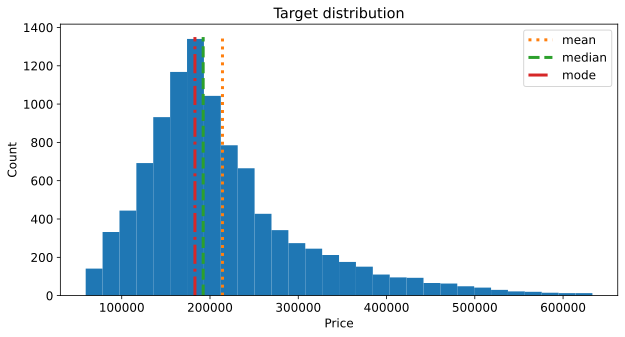

In [945]:
plt.hist(train_df['Price'], bins=30)

y = np.linspace(0, 1350, 10)
plt.plot([round(train_df['Price'].mean(), 2)] * 10, y, label='mean', linestyle=':', linewidth=3)
plt.plot([train_df['Price'].median()] * 10, y, label='median', linestyle='--', linewidth=3)
plt.plot([train_df['Price'].mode()[0]] * 10, y, label='mode', linestyle='-.', linewidth=3)

plt.title('Target distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()

plt.show()

### Анализ признаков

#### Количественные признаки

C:\Users\lisat\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


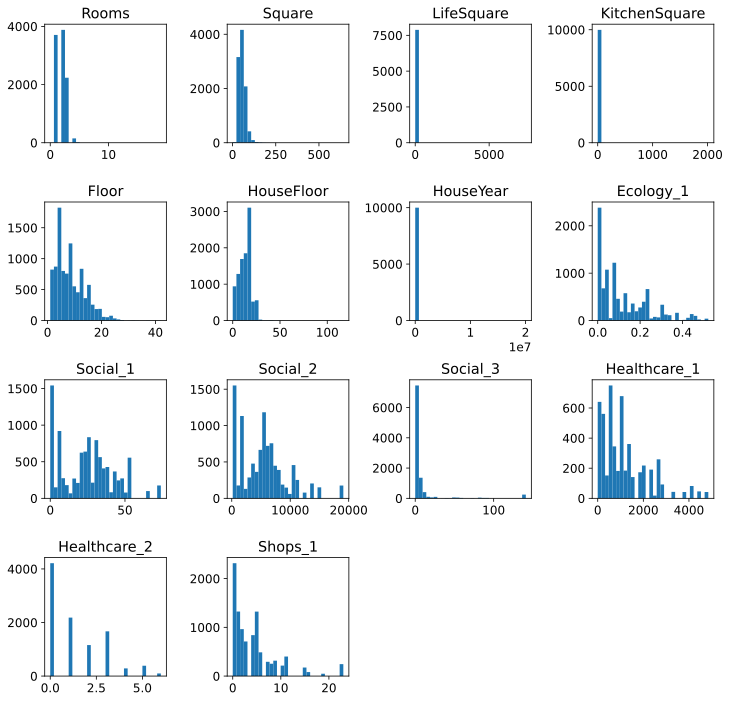

In [946]:
train_df = train_df.rename(columns={'Helthcare_2': 'Healthcare_2'})
train_df_num_features = train_df.select_dtypes(include=['float32', 'int32', 'int16', 'int8'])
train_df_num_features.drop('Price', axis=1, inplace=True)

train_df_num_features.hist(figsize=(12,12), bins=30, grid=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

#### Номинативные признаки

In [947]:
train_df.select_dtypes(include='object')

,Id,DistrictId
0,11809,27
1,3013,22
2,8215,1
3,2352,1
4,13866,94
...,...,...
9995,1260,61
9996,16265,27
9997,2795,178
9998,14561,21


In [948]:
len(train_df['Id']) == len(set(train_df['Id']))

True

In [949]:
train_df = train_df.drop('Id', axis=1)

In [950]:
train_df['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [951]:
train_df.select_dtypes(include='category')

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,A
9997,B,B,B
9998,B,B,B


In [952]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [953]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [954]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Анализ зависимостей целевой переменной и признаков

C:\Users\lisat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


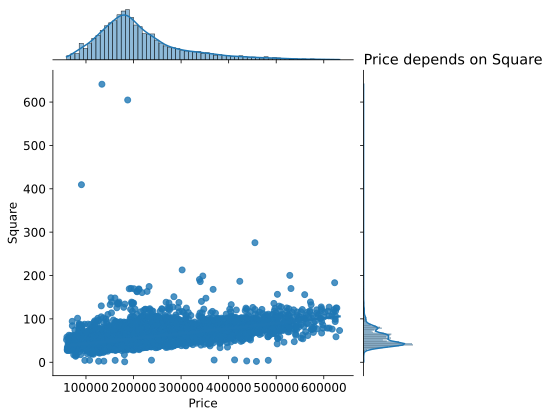

In [955]:
sns.jointplot( train_df['Price'], train_df['Square'], kind='reg')
plt.title('Price depends on Square', loc='left')
plt.show()

# Предобработка данных


## Oбработка пропусков

In [956]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  object  
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Healthcare_2   10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

#### Пропуски LifeSquare

In [957]:
train_df['LifeSquare'].median()

32.7812614440918

In [958]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.367616653442383

In [959]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

train_df['LifeSquare'].median()

34.07875061035156

   #### Пропуски Healthcare_1

In [960]:
train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median())

### Обработка выбросов
#### Выбросы в Square, Lifesquare, Kitchensquare


In [961]:
train_df['Square'].sort_values()

7470      1.136859
4496      1.988943
9869      2.377248
8572      2.596351
161       2.954309
           ...    
7644    212.932358
1906    275.645294
7010    409.425171
726     604.705994
9229    641.065186
Name: Square, Length: 10000, dtype: float32

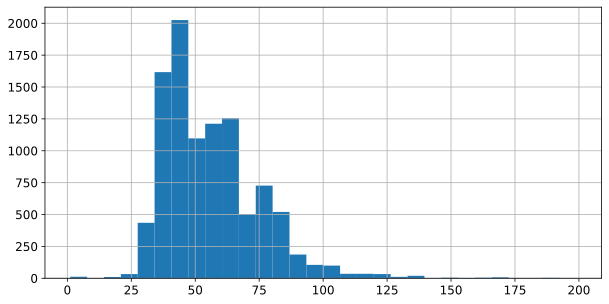

In [962]:
train_df.loc[train_df['Square'] < 200,'Square'].hist(bins=30)
plt.show()

In [963]:
train_df.loc[train_df['Square'] < 20, 'Square'] = 20
train_df.loc[train_df['Square'] > 200, 'Square'] = 200 

In [964]:
train_df['LifeSquare'].sort_values()

682       -8.508371
3113       0.370619
1829       0.641822
119        0.795539
9869       0.873147
           ...     
7010     410.639740
5183     461.463623
726      592.338379
9229     638.163208
8000    7480.592285
Name: LifeSquare, Length: 10000, dtype: float32

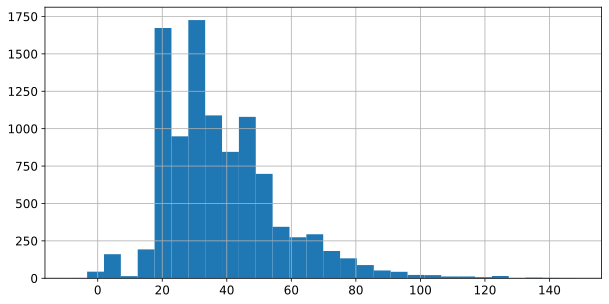

In [965]:
train_df.loc[train_df['LifeSquare'] < 150,'LifeSquare'].hist(bins=30)
plt.show()

In [966]:
train_df.loc[train_df['LifeSquare'] < 10,'LifeSquare'] = 10
train_df.loc[train_df['LifeSquare'] > 150,'LifeSquare'] = 150

In [967]:
train_df['KitchenSquare'].sort_values()

2178       0.0
5612       0.0
519        0.0
8814       0.0
3709       0.0
         ...  
7733     112.0
5002     112.0
286      123.0
6505    1970.0
9520    2014.0
Name: KitchenSquare, Length: 10000, dtype: float32

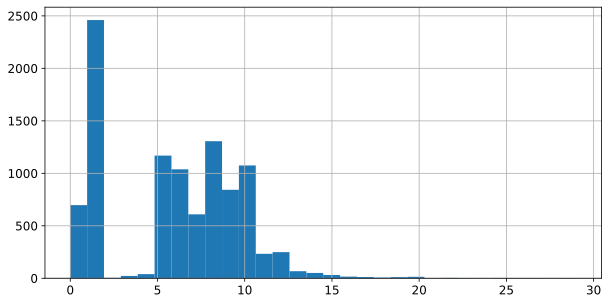

In [968]:
train_df.loc[train_df['KitchenSquare'] < 30,'KitchenSquare'].hist(bins=30)
plt.show()

In [969]:
train_df.loc[train_df['KitchenSquare'] < 4.5, 'KitchenSquare'] = 4.5
train_df.loc[train_df['KitchenSquare'] > 15, 'KitchenSquare'] = 15

#### Выбросы в Rooms

In [970]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [971]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [972]:
train_df['Rooms'].unique()

array([3., 1., 2., 4., 5., 6.], dtype=float32)

#### Выбросы в Floor, HouseFloor

In [973]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [974]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [975]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [976]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers.shape

(1610,)

In [977]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

#### Выбросы в HouseYear

In [978]:
train_df['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int32

In [979]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

In [980]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.223286,38.605339,6.882600,7.390700,12.959100,1984.872600,0.118858,24.687000,5352.157400,8.039200,1026.358887,1.319500,4.231300,214138.937500
std,0.812107,19.179222,18.537884,2.525245,5.019938,6.443573,18.416734,0.119025,17.532614,4006.799803,23.831875,746.644226,1.493601,4.806341,92872.273438
min,1.000000,20.000000,10.000000,4.500000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,24.523744,4.500000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,34.078751,6.000000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,47.648065,9.000000,10.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.460938
max,6.000000,200.000000,150.000000,15.000000,42.000000,117.000000,2021.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Генерация новых признаков

#### Категориальные признаки в бинарные

In [981]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

#### Median_price_by_district

In [982]:
median_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'Median_price_by_district'})

median_price_by_district.head()

,DistrictId,Rooms,Median_price_by_district
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [983]:
train_df = train_df.merge(median_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Median_price_by_district
0,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,B,...,0,900.0,0,0,B,305018.875000,1,1,1,213530.781250
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,...,1,1183.0,1,0,B,177734.546875,1,1,1,146032.828125
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,...,0,240.0,3,1,B,282078.718750,1,1,1,244005.281250
3,1,1.0,40.409908,28.042292,4.5,10,22.0,1977,0.007122,B,...,0,900.0,0,1,B,168106.000000,1,1,1,146735.671875
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,2,900.0,0,6,B,343995.093750,1,1,1,201584.437500


#### Median_price_by_square

In [984]:
median_price_by_square = train_df.groupby(['Square'], as_index=False).agg({'Price':'median'})\
                      .rename(columns={'Price':'Median_price_by_square'})
median_price_by_square.head()

,Square,Median_price_by_square
0,20.000000,126596.945312
1,20.213127,113050.226562
2,20.606762,108379.890625
3,20.924927,128808.085938
4,21.121279,113846.125000


In [985]:
train_df = train_df.merge(median_price_by_square, on='Square', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Median_price_by_district,Median_price_by_square
0,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,B,...,900.0,0,0,B,305018.875000,1,1,1,213530.781250,305018.875000
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,...,1183.0,1,0,B,177734.546875,1,1,1,146032.828125,177734.546875
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,...,240.0,3,1,B,282078.718750,1,1,1,244005.281250,282078.718750
3,1,1.0,40.409908,28.042292,4.5,10,22.0,1977,0.007122,B,...,900.0,0,1,B,168106.000000,1,1,1,146735.671875,168106.000000
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,900.0,0,6,B,343995.093750,1,1,1,201584.437500,343995.093750


#### House_age_category

In [986]:
now = datetime.datetime.now()

train_df['Median_house_age'] = now.year - train_df['HouseYear']
train_df['Median_house_age']. describe()

count    10000.000000
mean        37.127400
std         18.416734
min          1.000000
25%         21.000000
50%         45.000000
75%         48.000000
max        112.000000
Name: Median_house_age, dtype: float64

In [987]:
train_df['House_age_category'] = 0

train_df.loc[(train_df['Median_house_age'] <= 5), 'House_age_category'] = 1  
train_df.loc[(train_df['Median_house_age'] > 5) & (train_df['Median_house_age'] <= 10), 'House_age_category'] = 2    # new
train_df.loc[(train_df['Median_house_age'] > 10) & (train_df['Median_house_age'] <= 25), 'House_age_category'] = 3   # relatively new
train_df.loc[(train_df['Median_house_age'] > 25) & (train_df['Median_house_age'] <= 35), 'House_age_category'] = 4   # 90s
train_df.loc[(train_df['Median_house_age'] > 35) & (train_df['Median_house_age'] <= 65), 'House_age_category'] = 5   # probably panel houses and 'Хрущевки'
train_df.loc[(train_df['Median_house_age'] > 75), 'House_age_category'] = 6   # old

train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Median_price_by_district,Median_price_by_square,Median_house_age,House_age_category
0,27,3.0,115.027313,93.659698,10.0,4,10.0,2014,0.075424,B,...,0,B,305018.875000,1,1,1,213530.781250,305018.875000,8,2
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,...,0,B,177734.546875,1,1,1,146032.828125,177734.546875,56,5
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,...,1,B,282078.718750,1,1,1,244005.281250,282078.718750,34,4
3,1,1.0,40.409908,28.042292,4.5,10,22.0,1977,0.007122,B,...,1,B,168106.000000,1,1,1,146735.671875,168106.000000,45,5
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,6,B,343995.093750,1,1,1,201584.437500,343995.093750,50,5


#### Floor_category

In [988]:
train_df['Floor_category'] = 0

train_df.loc[(train_df['Floor'] <= 3), 'Floor_category'] = 1  
train_df.loc[(train_df['Floor'] > 3) & (train_df['Floor'] <= 5), 'Floor_category'] = 2
train_df.loc[(train_df['Floor'] > 5) & (train_df['Floor'] <= 10), 'Floor_category'] = 3
train_df.loc[(train_df['Floor'] > 10) & (train_df['Floor'] <= 20), 'Floor_category'] = 4
train_df.loc[(train_df['Floor'] > 20), 'Floor_category'] = 5

train_df.tail()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Median_price_by_district,Median_price_by_square,Median_house_age,House_age_category,Floor_category
9995,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,...,B,119367.453125,1,1,1,232514.843750,119367.453125,41,5,1
9996,27,2.0,64.307686,37.038422,9.0,13,13.0,1977,0.072158,B,...,A,199715.156250,1,1,0,165700.343750,199715.156250,45,5,4
9997,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,...,B,165953.906250,1,1,1,165953.906250,165953.906250,64,5,1
9998,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,...,B,171842.406250,1,1,1,153921.406250,171842.406250,53,5,1
9999,94,1.0,35.815475,22.301367,6.0,9,9.0,1975,0.127376,B,...,B,177685.625000,1,1,1,158830.640625,177685.625000,47,5,3


### Отбор признаков

In [989]:
train_df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Healthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'Ecology_2_bin', 'Ecology_3_bin',
       'Shops_2_bin', 'Median_price_by_district', 'Median_price_by_square',
       'Median_house_age', 'House_age_category', 'Floor_category'],
      dtype='object')

In [990]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
                 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Healthcare_2', 'Shops_1','Ecology_2_bin', 
                 'Ecology_3_bin', 'Shops_2_bin']
new_feature_names = ['Median_price_by_district', 'Median_price_by_square', 'Median_house_age', 'House_age_category',
                     'Floor_category']
target_name = ['Price']

## Разбиение на train и test

In [991]:
X = train_df[feature_names + new_feature_names]
y = np.ravel(train_df[target_name])
y.shape

(10000,)

In [992]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
y_valid.shape

(3000,)

# Построение модели
#### Отбор наилучших параметров для модели

In [993]:
#parameters = {'n_estimators': [150, 200], 'max_features': np.arange(15, 22), 'max_depth': np.arange(5, 10)}
#clf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameters, scoring='r2', cv=5)

In [994]:
#clf.fit(X_train, y_valid)

In [995]:
#clf.best_params_

#### Обучение модели

In [996]:
rf_model = RandomForestRegressor(n_estimators=150,
                                 max_depth=9,
                                 min_samples_leaf=30,
                                 max_features=16, 
                                 random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features=16, min_samples_leaf=30,
                      n_estimators=150, random_state=42)

#### Предсказания целевой переменной

Train R2:	0.988
Test R2:	0.996


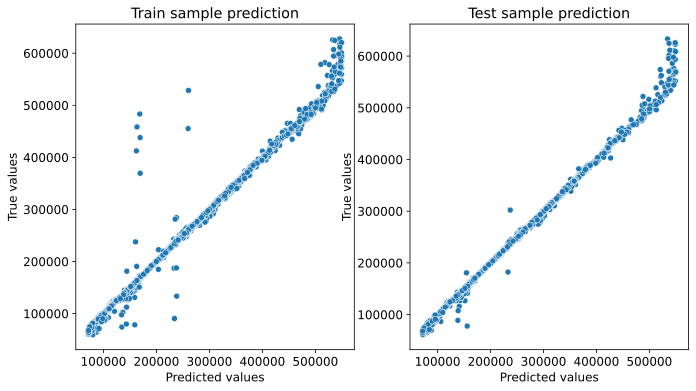

In [997]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Перекрёстная проверка

In [998]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score.mean()

0.9901573106629499

#### Важность признаков

In [999]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,Median_price_by_square,8.496120e-01
17,Median_price_by_district,1.146307e-01
1,Square,2.442552e-02
0,Rooms,7.058810e-03
8,Social_1,1.437263e-03
2,LifeSquare,8.107071e-04
3,KitchenSquare,5.581094e-04
9,Social_2,4.980938e-04
10,Social_3,3.091194e-04
6,HouseYear,1.328819e-04


In [1000]:
class DataPreprocessing:
    
    def __init__(self):
        '''Параметры класса'''
               
    
    def fit(self, df):
        '''Сохранение статистик'''
      
        # Расчёт медиан
        self.lifesquare_median = df['LifeSquare'].median()
        self.healthcare_1_median = df['Healthcare_1'].median()
        square_med_diff = (df.loc[df['LifeSquare'].notnull(), 'Square'] -\
                           df.loc[df['LifeSquare'].notnull(), 'LifeSquare'] -\
                           df.loc[df['LifeSquare'].notnull(), 'KitchenSquare']).median()
        self.rooms_median = df['Rooms'].median()
        self.house_floor_median = df['HouseFloor'].median()
                           
    def transform(self, df): 
        '''Трансформация данных'''
        df = df.drop('Id', axis=1)
        df['DistrictId'] = df['DistrictId'].astype(str)
        df = df.rename(columns={'Helthcare_2': 'Healthcare_2'})
        
        # Пропуски
        df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = \
            df.loc[df['LifeSquare'].isnull(), 'Square'] - df.loc[df['LifeSquare'].isnull(), 'KitchenSquare'] - square_med_diff
        df['Healthcare_1'] = df['Healthcare_1'].fillna(self.healthcare_1_median)
        
        # Выбросы
        df.loc[df['Square'] < 20, 'Square'] = 20
        df.loc[df['Square'] > 200, 'Square'] = 200
        df.loc[df['LifeSquare'] < 10,'LifeSquare'] = 10
        df.loc[df['LifeSquare'] > 150,'LifeSquare'] = 150
        df.loc[df['KitchenSquare'] < 4.5, 'KitchenSquare'] = 4.5
        df.loc[df['KitchenSquare'] > 15, 'KitchenSquare'] = 15
        df.loc[df['Rooms'].isin([0, 10, 19]), 'Rooms'] = self.rooms_median
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.house_floor_median
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        df.loc[df['HouseYear'] > 2021, 'HouseYear'] = 2021
        
        # Новые признаки
        df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
        df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
        df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
        
        now = datetime.datetime.now()
        df['Median_house_age'] = now.year - df['HouseYear']
        df['House_age_category'] = 0
        df.loc[(df['Median_house_age'] <= 5), 'House_age_category'] = 1  
        df.loc[(df['Median_house_age'] > 5) & (df['Median_house_age'] <= 10), 'House_age_category'] = 2    # new
        df.loc[(df['Median_house_age'] > 10) & (df['Median_house_age'] <= 25), 'House_age_category'] = 3   # relatively new
        df.loc[(df['Median_house_age'] > 25) & (df['Median_house_age'] <= 35), 'House_age_category'] = 4   # 90s
        df.loc[(df['Median_house_age'] > 35) & (df['Median_house_age'] <= 65), 'House_age_category'] = 5   # probably panel houses and 'Хрущевки'
        df.loc[(df['Median_house_age'] > 75), 'House_age_category'] = 6   # old
        
        df['Floor_category'] = 0
        df.loc[(df['Floor'] <= 3), 'Floor_category'] = 1  
        df.loc[(df['Floor'] > 3) & (df['Floor'] <= 5), 'Floor_category'] = 2
        df.loc[(df['Floor'] > 5) & (df['Floor'] <= 10), 'Floor_category'] = 3
        df.loc[(df['Floor'] > 10) & (df['Floor'] <= 20), 'Floor_category'] = 4
        df.loc[(df['Floor'] > 20), 'Floor_category'] = 5
        
        return df

In [1001]:
prepocessor = DataPreprocessing()
prepocessor.fit(test_df)
test_df = prepocessor.transform(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   DistrictId          5000 non-null   object  
 1   Rooms               5000 non-null   float32 
 2   Square              5000 non-null   float32 
 3   LifeSquare          5000 non-null   float32 
 4   KitchenSquare       5000 non-null   float32 
 5   Floor               5000 non-null   int64   
 6   HouseFloor          5000 non-null   float32 
 7   HouseYear           5000 non-null   int16   
 8   Ecology_1           5000 non-null   float32 
 9   Ecology_2           5000 non-null   category
 10  Ecology_3           5000 non-null   category
 11  Social_1            5000 non-null   int8    
 12  Social_2            5000 non-null   int16   
 13  Social_3            5000 non-null   int16   
 14  Healthcare_1        5000 non-null   float32 
 15  Healthcare_2        5000 non-null   in

In [1003]:
predictions = rf_model.predict(test_df)

ValueError: could not convert string to float: 'B'